# Tracking changes in SARS-CoV-2 transmission with a novel outpatient sentinel surveillance system in Chicago, USA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
import datetime
#sns.set(color_codes=True)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import statistics as st
sns.set_style('whitegrid', {'axes.linewidth' : 0.5})
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.proportion import proportions_ztest
import scipy
import gc

from helpers import *

In [2]:
import epyestim
import epyestim.covid19 as covid19

In [3]:
today_str = dt.datetime.today().strftime('%y%m%d')

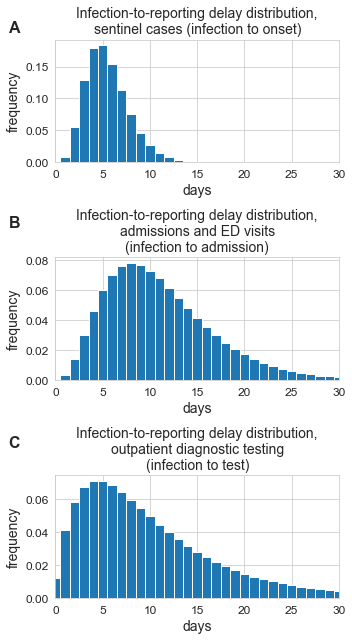

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,9))
alpha = 1
# Panel A ###################################################
my_continuous_distrb = scipy.stats.gamma(a=5.807, scale=0.948)
my_discrete_distrb = epyestim.discrete_distrb(my_continuous_distrb)
sc_distrb = my_discrete_distrb
axes[0].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[0].set_xlim([0,30])
axes[0].set_title('Infection-to-reporting delay distribution,\nsentinel cases (infection to onset)', fontsize=14)
axes[0].set_xlabel('days', fontsize=14)

# Panel B ###################################################
alpha1 = 5.807
theta1 = 0.948
#print(alpha1*theta1)
alpha2 = 1.104 #5.074 
theta2 = 5.074 #1.104
#print(alpha2*theta2)
k_sum = (alpha1*theta1 + alpha2*theta2)**2/((alpha1*theta1**2) + (alpha2*theta2**2))
theta_sum = (alpha1*theta1 + alpha2*theta2)/k_sum

k_sum = (alpha1*theta1 + alpha2*theta2)**2/((alpha1*theta1**2) + (alpha2*theta2**2))
theta_sum = (alpha1*theta1 + alpha2*theta2)/k_sum

#print(k_sum, theta_sum)
#print(k_sum*theta_sum)

my_continuous_distrb = scipy.stats.gamma(a=k_sum, scale=theta_sum)
my_discrete_distrb = epyestim.discrete_distrb(my_continuous_distrb)
#my_discrete_distrb = covid19.generate_standard_infection_to_reporting_distribution()
cli_distrb = my_discrete_distrb
axes[1].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[1].set_xlim([0,30])
axes[1].set_title('Infection-to-reporting delay distribution,\nadmissions and ED visits\n(infection to admission)', fontsize=14)
axes[1].set_xlabel('days', fontsize=14)

# Panel C ###################################################
case_distrb = covid19.generate_standard_infection_to_reporting_distribution()
my_discrete_distrb = case_distrb
axes[2].bar(range(len(my_discrete_distrb)), my_discrete_distrb, width=1, alpha=alpha)
axes[2].set_xlim([0,30])
axes[2].set_title('Infection-to-reporting delay distribution,\noutpatient diagnostic testing\n(infection to test)', fontsize=14)
axes[2].set_xlabel('days', fontsize=14)

#print(k_sum, theta_sum)
#print(k_sum*theta_sum)
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylabel('frequency', fontsize=14)

fig.text(y=0.95, x=0.05, s='A', va='center', ha='center', fontsize=16, weight='bold')
fig.text(y=0.65, x=0.05, s='B', va='center', ha='center', fontsize=16, weight='bold')
fig.text(y=0.31, x=0.05, s='C', va='center', ha='center', fontsize=16, weight='bold')
fig.tight_layout()
fig.savefig('supp_fig_1_'+ today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('supp_fig_1_'+ today_str + '.pdf', bbox_inches='tight')

In [5]:
np.sum(case_distrb*np.arange(len(case_distrb)))

10.335982624278122

In [6]:
print(med_and_iqr(sc_distrb))
print(med_and_iqr(cli_distrb))
print(med_and_iqr(case_distrb))

(5, (4, 7))
(10, (7, 14))
(8, (4, 14))


# Retrieving archived data

In [7]:
#Retrieving archived data
# CLI hospitalizations
cli = pd.read_csv('./data/CLI_admissions_210825.csv') #Good! This is actual CLI
cli['date'] = pd.to_datetime(cli['date'], utc=True)
cli_series = cli[cli['region'] == 'Chicago'].groupby('date').sum()['inpatient']

np.random.seed(2022)
r_cli = covid19.r_covid(cli_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

# ED visits (CLI & covid-confirmed)
cli_ed = pd.read_csv('./data/ed_visits_chicago_210923.csv')
cli_ed['date'] = pd.to_datetime(cli_ed['date'], utc=True)

covid_ed_series = cli_ed.set_index('date')['total_covid_daily']
covid_ed_series = covid_ed_series.dropna()
np.random.seed(2022)
r_covid_ed = covid19.r_covid(covid_ed_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

cli_ed_series = cli_ed.set_index('date')['total_cli_daily']
cli_ed_series = cli_ed_series.dropna()
np.random.seed(2022)
r_cli_ed = covid19.r_covid(cli_ed_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

# Confirmed hospitalizations
cli_cdph = pd.read_csv('./data/hospitalizations_chicago_210923.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['date'], utc=True)

cli_cdph_series = cli_cdph.set_index('date')['hospitalizations_total']
cli_cdph_series = cli_cdph_series.dropna()

np.random.seed(2022)
r_cli_cdph = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)
#r_cli_cdph_partial = covid19.r_covid(cli_cdph_series, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=False)

# Confirmed hospitalizations
cli_cdph = pd.read_csv('./data/hospitalizations_chicago_210923.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['date'], utc=True)

# cases
case_series = cli_cdph.set_index('date')['cases_total']
case_series = case_series.dropna()
np.random.seed(2022)
r_case = covid19.r_covid(case_series, delay_distribution=case_distrb, r_window_size=14, auto_cutoff=True)

In [8]:
curative = pd.read_csv('./data/2021.07.06 Master Set Data Only_Deidentified.csv', encoding= 'unicode_escape')
curative['patient_symptom_date'] = pd.to_datetime(curative['patient_symptom_date'], errors='coerce')
curative['collection_time'] = pd.to_datetime(curative['collection_time'], errors='coerce')
curative['days'] = (pd.to_datetime(curative['collection_time'], utc=True) - pd.to_datetime(curative['patient_symptom_date'], utc=True)).dt.days

C:\Users\richa\anaconda3\envs\covid_env\lib\site-packages\IPython\core\interactiveshell.py:3134: DtypeWarning: Columns (0,4,10,11,13,15,16,18,19,20,21,22,23,24,25,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
# tests from curative in time frame
len(curative[(curative['collection_time'] >= pd.to_datetime('09-27-2020')) & 
         (curative['collection_time'] <= pd.to_datetime('6-13-2021'))])

274343

In [10]:
idph =  pd.read_csv('./data/210706_SS_epic.csv', encoding= 'unicode_escape')
idph['test_date'] = pd.to_datetime(idph['test_date'])
idph['test_time'] = pd.to_datetime(idph['test_time'])
idph['date_symptoms_start'] = pd.to_datetime(idph['date_symptoms_start'])
idph['days'] = (idph['test_date'] - idph['date_symptoms_start']).dt.days
ss_cond = (idph['days'] <= 4) & (idph['days'] >= 0)
pos_cond = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
chi_cond = (idph['test_site_city'] == 'CHICAGO')

In [11]:
# tests from IDPH in time frame
len(idph[(idph['test_date'] >= pd.to_datetime('09-27-2020')) & (idph['test_date'] <= pd.to_datetime('6-13-2021'))])

384559

In [12]:
zips = pd.read_csv('./data/Chicago_ZIP_codes.txt', header=None)[0].values

In [13]:
idph['chicago'] = idph['pat_zip_code'].apply(lambda x: zip_in_zips(x, zips))

In [14]:
curative['chicago'] = curative['patient_city'] == 'Chicago'

In [15]:
curative_time_frame_cond = (curative['collection_time'] >= pd.to_datetime('9-27-20')) & (curative['collection_time'] <= pd.to_datetime('6-13-21'))
curative_ss = (curative['days'] >= 0) & (curative['days'] <= 4)
curative_symptom = curative['patient_is_symptomatic']

idph_time_frame_cond = (idph['test_date'] >= pd.to_datetime('9-27-20')) & (idph['test_date'] <= pd.to_datetime('6-13-21'))
idph_ss = (idph['days'] >= 0) & (idph['days'] <= 4)
idph_symptom = idph['symptomatic_per_cdc'] == 'Yes'
idph_chicago_site = (idph['test_site'] == 'IDPH COMMUNITY TESTING AUBURN GRESHAM') | (idph['test_site'] == 'IDPH AUBURN GRESHAM COMMUNITY TESTING') | (idph['test_site'] == 'IDPH HARWOOD HEIGHTS COMMUNITY TESTING')

idph_count = np.sum(idph_time_frame_cond & idph_ss & idph['chicago'] & idph_chicago_site)
curative_count = np.sum(curative_time_frame_cond & curative_ss & curative['chicago'])

print(idph_count)
print(curative_count)

7478
6474


In [16]:
idph[(idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')]['test_site'].value_counts()

IDPH HARWOOD HEIGHTS COMMUNITY TESTING                        31790
IDPH COMMUNITY TESTING AUBURN GRESHAM                         10323
IDPH AUBURN GRESHAM COMMUNITY TESTING                          9095
IDPH BENNETT DAY MOBILE TESTING                                 195
IDPH MCCORMICK YMCA MOBILE TESTING                               73
IDPH SAN LUCAS CHURCH MOBILE TESTING                             22
IDPH REP RAMIREZ/SEN AQUINO OFFICE MOBILE TESTING                17
IDPH MADISON AND PULASKI COMMUNITY POP UP MOBILE TESTING         12
IDPH METROPOLITAN FAMILY SERVICES MOBILE TESTING                 12
IDPH K.L.E.O. COMMUNITY FAMILY LIFE CENTER MOBILE TESTING         9
IDPH LIFE CENTER CHURCH OF GOD IN CHRIST MOBILE TESTING           8
IDPH METROPOLITAN FAMILY SERVICES - BELMONT MOBILE TESTING        5
IDPH MOBILE TESTING BERNARD HORWICH JCC                           2
Name: test_site, dtype: int64

In [17]:
idph_slice = idph[(idph['test_site'] == 'IDPH COMMUNITY TESTING AUBURN GRESHAM') | 
                  (idph['test_site'] == 'IDPH AUBURN GRESHAM COMMUNITY TESTING')]

print(len(idph_slice[(idph_slice['test_date'] >= pd.to_datetime('09-27-2020')) & 
               (idph_slice['test_date'] <= pd.to_datetime('6-13-2021'))]))

(idph_slice.groupby('test_date').count()['pat_id'].reindex(pd.date_range('5-1-2020', '06-30-2021'), fill_value=0.0) > 0).to_csv('auburn_gresham.csv')

idph_slice = idph[(idph['test_site'] == 'IDPH HARWOOD HEIGHTS COMMUNITY TESTING')]
print(len(idph_slice[(idph_slice['test_date'] >= pd.to_datetime('09-27-2020')) & 
               (idph_slice['test_date'] <= pd.to_datetime('6-13-2021'))]))
(idph_slice.groupby('test_date').count()['pat_id'].reindex(pd.date_range('5-1-2020', '06-30-2021'), fill_value=0.0) > 0).to_csv('harwood_heights.csv')

19325
31204


In [18]:
cap = 40
idx = pd.date_range('9-27-2020', '06-13-2021')
pos_cond_curative = curative['test_result'] == 'POSITIVE'
curative['positive'] = pos_cond_curative
chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
idph['positive'] = pos_cond_idph
all_cases = pd.DataFrame(columns=['date', 'positive'])
collect_cases = pd.DataFrame(columns=['date', 'positive'])
combo_ss = np.zeros(len(idx))
combo_sc = np.zeros(len(idx))
combo_adjust = np.zeros(len(idx))
for date in idx:
    idph_slice = idph[ss_cond & idph['chicago'] & chi_idph & idph_chicago_site & (idph['test_date'] == date)].sort_values('test_time')
    idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
    curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & (curative['days'] >= 0) & (curative['days'] <= 4)]
    curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
    combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
    combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
    collect_cases = collect_cases.append(combo_short[0:cap])
    #collect_cases = collect_cases.append(combo_short)
    all_cases = all_cases.append(combo_short)

In [19]:
collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
onset_idx = idx
combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()

In [20]:
combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
#combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
combo_ss = (all_cases).groupby(all_cases['date']).count()
#combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
combo_adjust.index = pd.to_datetime(combo_adjust.index)
#combo_adjust.reindex(onset_idx, fill_value=0.0)

In [21]:
print(len(all_cases))
print(all_cases['positive'].sum())

13952
3607


In [22]:
print('Total specimens (curative): ' + str(len(curative[curative_time_frame_cond]['patient_is_symptomatic'])))
print('Total specimens (curative) with documented symptomatology: ' + str(len(curative[curative_time_frame_cond].dropna(subset=['patient_is_symptomatic']))))
print('Total specimens (IDPH): ' + str(len(idph[idph_time_frame_cond & idph_chicago_site])))
print('Total specimens (IDPH) with documented symptomatology: ' + str(np.sum((idph[idph_time_frame_cond & idph['chicago'] & idph_chicago_site]['symptomatic_per_cdc'] == 'Yes') | (idph[idph_time_frame_cond & idph['chicago'] & idph_chicago_site]['symptomatic_per_cdc'] == 'No'))))

Total specimens (curative): 274343
Total specimens (curative) with documented symptomatology: 89534
Total specimens (IDPH): 50529
Total specimens (IDPH) with documented symptomatology: 37104


# comparing timeseries when age-stratified

In [23]:
%%time
r_storage = []
# ages < 60
ages = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
np.random.seed(2022)
# generating raw sentinel case and adjusted sentinel case time series
for cap in [1000]:
    idx = pd.date_range('9-27-2020', '06-13-2021')
    pos_cond_curative = curative['test_result'] == 'POSITIVE'
    curative['positive'] = pos_cond_curative
    pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
    idph['positive'] = pos_cond_idph
    chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
    all_cases = pd.DataFrame(columns=['date', 'positive'])
    collect_cases = pd.DataFrame(columns=['date', 'positive'])
    combo_ss = np.zeros(len(idx))
    combo_sc = np.zeros(len(idx))
    combo_adjust = np.zeros(len(idx))
    for date in idx:
        idph_slice = idph[idph_chicago_site & ss_cond & idph['chicago'] & chi_idph & (idph['test_date'] == date) & 
                          (idph['age'] < 60)].sort_values('test_time')
        idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
        curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & 
                                  (curative['days'] >= 0) & (curative['days'] <= 4) & 
                                  (curative['age_group'].isin(ages[0:5]))]
        curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
        combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
        combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
        collect_cases = collect_cases.append(combo_short[0:cap])
        #collect_cases = collect_cases.append(combo_short)
        all_cases = all_cases.append(combo_short)
    collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
    all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
    onset_idx = idx
    combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()
    combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
    #combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
    combo_ss = (all_cases).groupby(all_cases['date']).count()
    #combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
    combo_adjust.index = pd.to_datetime(combo_adjust.index)
    combo_adjust.reindex(onset_idx, fill_value=0.0)
    np.random.seed(2022)
    r_combo_adjust = covid19.r_covid(combo_adjust[1:], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_storage.append(r_combo_adjust.copy())

np.random.seed(2022)
r_combo_adjust = covid19.r_covid(combo_ss['positive'], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

tpr = pd.DataFrame(index = combo_sc.index, data={'cases':combo_ss['positive'].mean()*combo_sc.values.astype(int)/combo_ss['positive'].values})['cases']
np.random.seed(2022)
r_combo_adjust = covid19.r_covid(tpr[1:], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

# ages >= 60
ages = ['0-17', '18-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
np.random.seed(2022)
# generating raw sentinel case and adjusted sentinel case time series
for cap in [1000]:
    idx = pd.date_range('9-27-2020', '06-13-2021')
    pos_cond_curative = curative['test_result'] == 'POSITIVE'
    curative['positive'] = pos_cond_curative
    pos_cond_idph = (idph['result'] == 'DETECTED') | (idph['result'] == 'POSITIVE')  | (idph['result'] == 'Detected')
    idph['positive'] = pos_cond_idph
    chi_idph = (idph['test_site_city'] == 'Chicago') | (idph['test_site_city'] == 'CHICAGO')
    all_cases = pd.DataFrame(columns=['date', 'positive'])
    collect_cases = pd.DataFrame(columns=['date', 'positive'])
    combo_ss = np.zeros(len(idx))
    combo_sc = np.zeros(len(idx))
    combo_adjust = np.zeros(len(idx))
    for date in idx:
        idph_slice = idph[idph_chicago_site & ss_cond & idph['chicago'] & chi_idph & (idph['test_date'] == date) & 
                          (idph['age'] >= 60)].sort_values('test_time')
        idph_short = pd.DataFrame(idph_slice[['date_symptoms_start', 'positive']]).rename(columns={'date_symptoms_start':'date'})
        curative_slice = curative[curative['chicago'] & (curative['collection_time'] == date) & 
                                  (curative['days'] >= 0) & (curative['days'] <= 4) & 
                                  (curative['age_group'].isin(ages[5:]))]
        curative_short = pd.DataFrame(curative_slice[['patient_symptom_date', 'positive']]).rename(columns={'patient_symptom_date':'date'})
        combo_short = curative_short.append(idph_short).sample(frac=1, random_state=0)
        combo_short['date'] = pd.to_datetime(combo_short['date'], utc=True).dt.date
        collect_cases = collect_cases.append(combo_short[0:cap])
        #collect_cases = collect_cases.append(combo_short)
        all_cases = all_cases.append(combo_short)
    collect_cases['date'] = pd.to_datetime(collect_cases['date'], utc=True)
    all_cases['date'] = pd.to_datetime(all_cases['date'], utc=True)
    onset_idx = idx
    combo_adjust = (collect_cases['positive']).groupby(collect_cases['date']).sum()
    combo_sc = (all_cases['positive']).groupby(all_cases['date']).sum()
    #combo_sc = combo_sc.reindex(onset_idx, fill_value=0.0)
    combo_ss = (all_cases).groupby(all_cases['date']).count()
    #combo_ss = combo_ss.reindex(onset_idx, fill_value=0.0)
    combo_adjust.index = pd.to_datetime(combo_adjust.index)
    combo_adjust.reindex(onset_idx, fill_value=0.0)
    np.random.seed(2022)
    combo_adjust = combo_adjust.reindex(pd.to_datetime(onset_idx, utc=True), fill_value=0.0)
    r_combo_adjust = covid19.r_covid(combo_adjust, delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
    r_storage.append(r_combo_adjust.copy())

np.random.seed(2022)
combo_sc = combo_sc.reindex(pd.to_datetime(onset_idx, utc=True), fill_value=0.0)
combo_ss = combo_ss.reindex(pd.to_datetime(onset_idx, utc=True), fill_value=0.0)
r_combo_adjust = covid19.r_covid(combo_ss['positive'], delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

tpr = pd.DataFrame(index = combo_sc.index, data={'cases':combo_ss['positive'].mean()*combo_sc.values.astype(int)/combo_ss['positive'].values})['cases']
np.random.seed(2022)
r_combo_adjust = covid19.r_covid(tpr[1:].fillna(0.0), delay_distribution=sc_distrb, r_window_size=14, auto_cutoff=True)
r_storage.append(r_combo_adjust.copy())

<timed exec>:104: RuntimeWarning: invalid value encountered in true_divide


CPU times: total: 16.6 s
Wall time: 16.7 s


In [24]:
len(r_storage)

6

In [25]:
# import age-stratified ED visits
ed_age = pd.read_csv('./data/220209_age_ed_visits_all.csv')
ed_age['date'] = pd.to_datetime(ed_age['date'], utc=True)
ed_age['under_60'] = ed_age[['0-17', '18-29', '30-39', '40-49', '50-59']].sum(axis=1)
ed_age['over_60'] = ed_age[['60-69', '70-79','80+']].sum(axis=1)
ed_series_under_60 = ed_age.set_index('date')['under_60']
ed_series_over_60 = ed_age.set_index('date')['over_60']

# import age-stratified hospitalizations and cases
cli_cdph = pd.read_csv('https://data.cityofchicago.org/resource/naz8-j4nc.csv')
cli_cdph['date'] = pd.to_datetime(cli_cdph['lab_report_date'], utc=True)
cli_cdph = cli_cdph.sort_values('date').reset_index(drop=True).dropna(subset=['date'])
cli_cdph['under_60'] = cli_cdph[['hospitalizations_age_0_17', 'hospitalizations_age_18_29',
       'hospitalizations_age_30_39', 'hospitalizations_age_40_49',
       'hospitalizations_age_50_59']].sum(axis=1)
cli_cdph['over_60'] = cli_cdph[['hospitalizations_age_60_69',
       'hospitalizations_age_70_79', 'hospitalizations_age_80_']].sum(axis=1)

cli_cdph_series_under_60 = cli_cdph.set_index('date')['under_60']
cli_cdph_series_over_60 = cli_cdph.set_index('date')['over_60']

cli_cdph['under_60'] = cli_cdph[['cases_age_0_17', 'cases_age_18_29',
       'cases_age_30_39', 'cases_age_40_49', 'cases_age_50_59']].sum(axis=1)
cli_cdph['over_60'] = cli_cdph[['cases_age_60_69', 'cases_age_70_79', 'cases_age_80_']].sum(axis=1)

case_series_under_60 = cli_cdph.set_index('date')['under_60']
case_series_over_60 = cli_cdph.set_index('date')['over_60']

In [26]:
np.random.seed(2022)
r_case_under_60 = covid19.r_covid(case_series_under_60, delay_distribution=case_distrb, r_window_size=14, auto_cutoff=True)
np.random.seed(2022)
r_case_over_60 = covid19.r_covid(case_series_over_60, delay_distribution=case_distrb, r_window_size=14, auto_cutoff=True)

np.random.seed(2022)
r_ed_under_60 = covid19.r_covid(ed_series_under_60, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)
np.random.seed(2022)
r_ed_over_60 = covid19.r_covid(ed_series_over_60, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

np.random.seed(2022)
r_cli_cdph_under_60 = covid19.r_covid(cli_cdph_series_under_60, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)
np.random.seed(2022)
r_cli_cdph_over_60 = covid19.r_covid(cli_cdph_series_over_60, delay_distribution=cli_distrb, r_window_size=14, auto_cutoff=True)

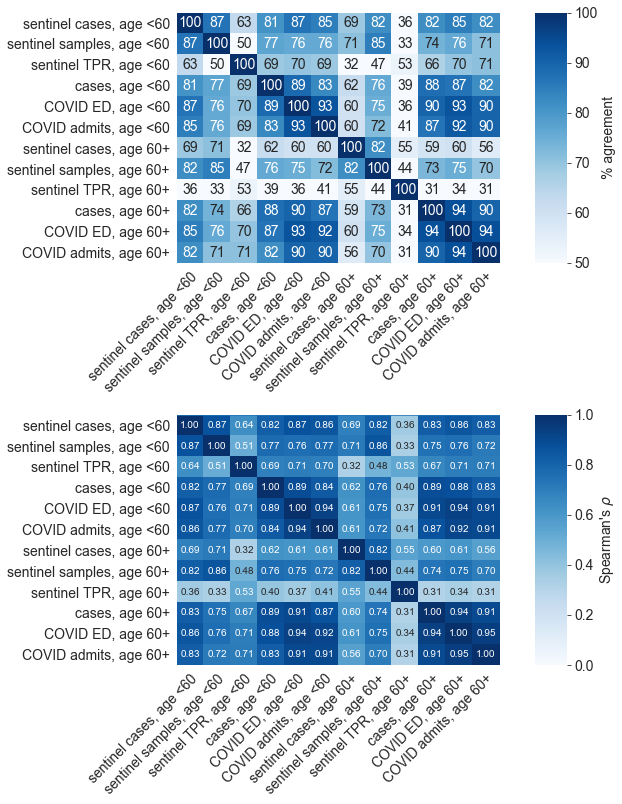

In [27]:
fig = plt.figure(constrained_layout=False, figsize=(7,12))
gs = fig.add_gridspec(3, 2, width_ratios=[1,0.1], height_ratios=[1,0.3,1])
axes = []
r_comparison_array = [r_storage[0], r_storage[1], r_storage[2], 
                      r_case_under_60, r_ed_under_60, r_cli_cdph_under_60, 
                      r_storage[3], r_storage[4], r_storage[5], 
                      r_case_over_60, r_ed_over_60, r_cli_cdph_over_60]
r_comparison_array_labels = ['sentinel cases, age <60', 
                             'sentinel samples, age <60', 
                             'sentinel TPR, age <60', 
                             'cases, age <60',
                             'COVID ED, age <60', 
                             'COVID admits, age <60', 
                             'sentinel cases, age 60+', 
                             'sentinel samples, age 60+', 
                             'sentinel TPR, age 60+', 
                             'cases, age 60+',
                             'COVID ED, age 60+', 
                             'COVID admits, age 60+']

similarity_matrix = np.zeros(shape=(len(r_comparison_array), len(r_comparison_array)))
for i in range(len(r_comparison_array)):
    for j in range(len(r_comparison_array)):
        similarity_matrix[i][j] = percent_agreement(r_comparison_array[i], 
                                                    r_comparison_array[j], 
                                                    'Q0.5', 
                                                    min_date=pd.to_datetime('2020-09-27', utc=True), 
                                                    max_date=pd.to_datetime('2021-06-07', utc=True))
        #print(spearmanr(r_comparison_array[i], r_comparison_array[j], 'Q0.5')[1])

# agreement
ax = fig.add_subplot(gs[0,0])
cbax = fig.add_subplot(gs[0,-1])
#axes.append(ax)
#axes.append(cbax)
g = sns.heatmap((100*similarity_matrix).astype(int), vmin=50, vmax=100, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='d', annot_kws={'fontsize':14})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
cbax.tick_params(labelsize=14)
cbax.set_ylabel('% agreement', rotation=90, fontsize=14)

# spearman
ax = fig.add_subplot(gs[2,0])
cbax = fig.add_subplot(gs[2,-1])
axes.append(ax)
axes.append(cbax)
g = sns.heatmap((similarity_matrix), vmin=0, vmax=1, cmap='Blues', square=False, cbar=True, 
                xticklabels=r_comparison_array_labels, yticklabels=r_comparison_array_labels, ax=ax, cbar_ax=cbax, 
                annot=True, fmt='.2f', annot_kws={'fontsize':10})
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 14, rotation=45, rotation_mode='anchor', ha='right', va='top')
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 14)
g.axhline(0)
cbax.tick_params(labelsize=14)
cbax.set_ylabel("Spearman's " + r'$\rho$', rotation=90, fontsize=14)
fig.savefig('age_strat_comparison_matrices_' + today_str + '.png', dpi=200, bbox_inches='tight')
fig.savefig('age_strat_comparison_matrices_' + today_str + '.pdf', bbox_inches='tight')